In [6]:
import ete3
import os
import random
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
from scipy.stats import spearmanr, linregress
import itertools
from Bio import SeqIO, SearchIO, AlignIO, Align, Alphabet
import re
import multiprocessing
from copy import deepcopy
from scipy.stats import ttest_ind

class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

os.chdir('/work/site_rate/hug_et_al/branch_length_evolution')
num_threads = 10

In [ ]:
alignment = AlignIO.read('../ribosomal_concat.fasta', 'fasta')

random.seed(12345)
for percentage in np.linspace(0.1,0.9,9):
    for n in range(100):
        tree = ete3.Tree('../ribosomal_concat_ml_tree-regular_support.tre')
        sampled_genes = random.sample(alignment, int(3083*percentage))
        SeqIO.write(sampled_genes, 'percentage_%i.fasta' % (percentage*100), 'fasta')
        tree.prune([seq.name for seq in sampled_genes])
        tree.write(outfile='percentage_%i.tree' % (percentage*100), format=5)

        subprocess.call(['iqtree', '-te', 'percentage_%i.tree' % (percentage*100),
                         '-s', 'percentage_%i.fasta' % (percentage*100), '-m', 'LG+G+F',
                         '-nt', '18', '-pre', 'percentage_%i_%i' % (n, percentage*100),
                         '-redo'])

In [110]:
branch_lengths_summaries = []
for percentage in np.linspace(0.1,0.9,9):
    print percentage*100
    branch_lengths_summaries.append([])
    for replicate in range(100):
        tree = ete3.Tree('percentage_%i_%i.treefile' % (replicate, percentage*100))
        branch_lengths_summaries[-1].append(np.median([node.dist for node in tree.traverse()
                                           if not node.is_leaf() or not node.is_root()]))

10.0
20.0
30.000000000000004
40.0
50.0
60.0
70.0
80.0
90.0


In [111]:
br_length_df = pd.DataFrame(columns='sampling_percentage mean'.split())
for summaries, percentage in zip(branch_lengths_summaries, np.linspace(0.1,0.9,9)):
    tmp_df = pd.DataFrame(columns='sampling_percentage mean'.split(),
                         data=zip([int(percentage*100)]*len(summaries), summaries))
    br_length_df = br_length_df.append(tmp_df, ignore_index=True)

Text(0.5,0,'Percentage of sampled leaves (%)')

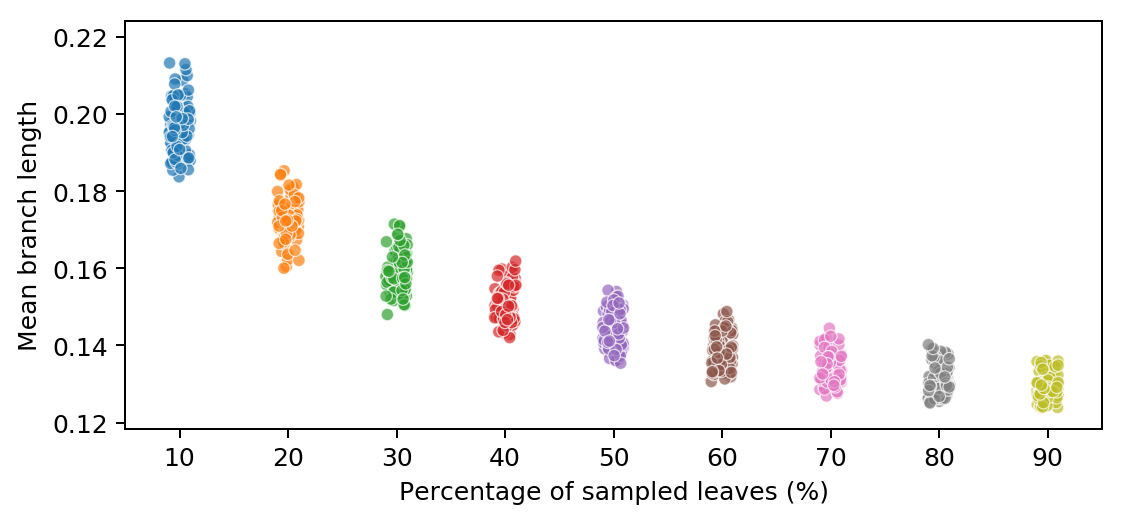

In [109]:
fig, ax = plt.subplots(dpi=180, figsize=(7,3))
sns.stripplot(x='sampling_percentage', y='mean', data=br_length_df, alpha=0.7, edgecolor='white', linewidth=0.5, ax=ax)
ax.set_ylabel('Mean branch length')
ax.set_xlabel('Percentage of sampled leaves (%)')

Text(0.5,0,'Percentage of sampled leaves (%)')

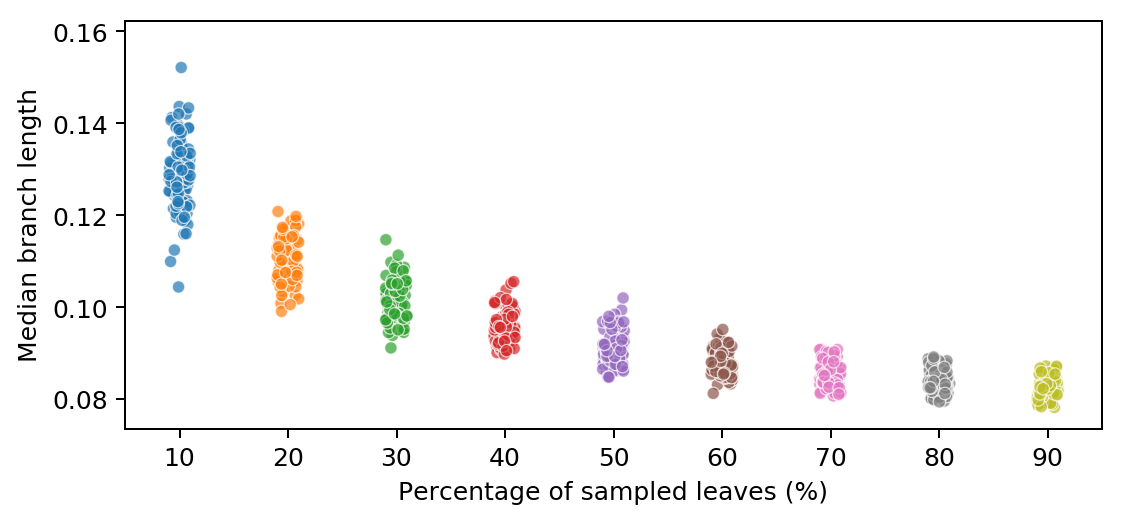

In [112]:
fig, ax = plt.subplots(dpi=180, figsize=(7,3))
sns.stripplot(x='sampling_percentage', y='mean', data=br_length_df, alpha=0.7, edgecolor='white', linewidth=0.5, ax=ax)
ax.set_ylabel('Median branch length')
ax.set_xlabel('Percentage of sampled leaves (%)')

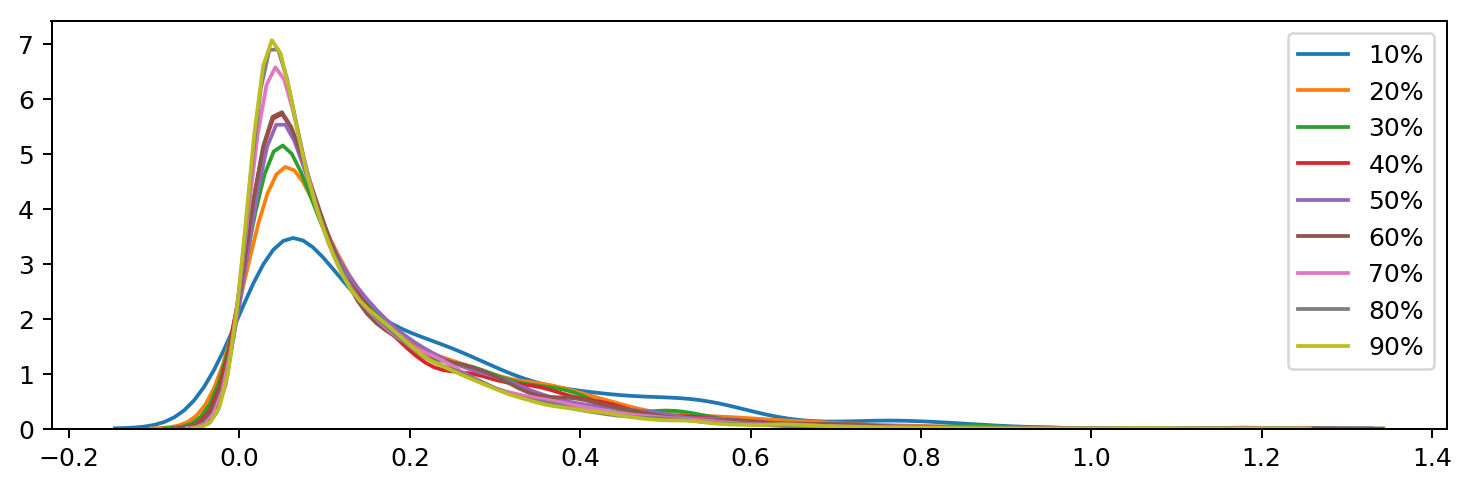

In [67]:
fig, axs = plt.subplots(figsize=(10,3), dpi=180)
#for data, ax in zip(branch_lengths, axs):
for data, percentage in zip(branch_lengths, np.linspace(0.1,0.9,9)):
    sns.kdeplot(data, shade=False, ax=axs, label='%i%%' % (percentage*100))